In [22]:
# import pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# import other libraries
import tqdm
import matplotlib.pyplot as plt
import numpy as np

# import specific functions
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

# import custom functions
from interpolate import interpolate

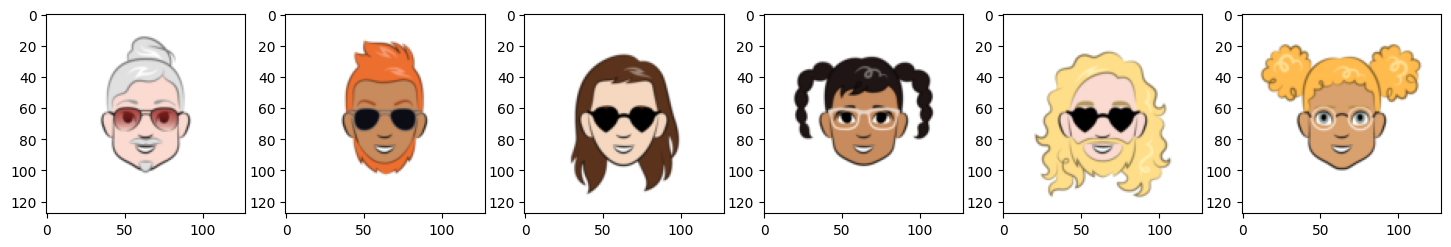

In [2]:
# define transformations (resize, to tensor, normalize)

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

# import custom cartoon dataset
# download dataset from https://google.github.io/cartoonset/

dataset = datasets.ImageFolder(root='data/Cartoon/', transform=transform)

fig, ax = plt.subplots(1, 6, figsize=(18, 3))
for i in range(6):
    ax[i].imshow(dataset[i][0].permute(1, 2, 0))

# make a dataloader and split into train and test sets
    
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

train, test = train_test_split(dataset, test_size=0.2)
test, val = train_test_split(test, test_size=0.5)

trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)

In [3]:
# implement convolutional variational autoencoder appropriate for the cartoon dataset

class VAE(nn.Module):
    def __init__(self, BOTTLENECK_SIZE=64, INPUT_SIZE=128):
        super(VAE, self).__init__()

        self.bottleneck = BOTTLENECK_SIZE
        self.input_size = INPUT_SIZE


        # construct en- and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        #define loss function and optimizer
        self.mse_loss_function = nn.MSELoss(reduction='mean')
        self.mse_weight = 1000

        # define optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=1e-5)

    def loss_function(self, x, x_hat, mu, log_var):
        mse_loss = self.mse_loss_function(x_hat, x)
        kl_loss = torch.mean(-0.5 * sum(1 + log_var - torch.square(mu) - torch.square(torch.exp(log_var))))


        return self.mse_weight * mse_loss + kl_loss

    def construct_encoder(self):
        encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(int(512*(self.input_size/(2**5))**2), 2 * self.bottleneck)
        )

        return encoder
    
    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def construct_decoder(self):
        decoder = nn.Sequential(
            nn.Linear(self.bottleneck, int(512*(self.input_size/(2**5))**2)),
            nn.ReLU(),
            nn.Unflatten(1, (512, int(self.input_size/(2**5)), int(self.input_size/(2**5)))),

            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
        return decoder
    
    def forward(self, x):
        # encode
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        z = self.reparameterise(mu, logvar)

        # decode
        x = self.decoder(z)
        return x, mu, logvar


In [4]:
# define training loop

def train_vae(model, X_train, X_val, n_epochs=10, verbose=True):
    loss_history = {
        'train': [],
        'val': []
    }

    if verbose:
        pbar = tqdm.tqdm(range(n_epochs))
    else:
        pbar = range(n_epochs)
    
    for epoch in pbar:
        # training
        model.train()
        train_loss = 0
        for batch in tqdm.tqdm(X_train):
            batch, _ = batch
            model.optimizer.zero_grad()
            output, mu, log_var = model(batch)
            loss = model.loss_function(batch, output, mu, log_var)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        loss_history['train'].append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in X_val:
                batch, _ = batch
                output, mu, log_var = model(batch)
                loss = model.loss_function(batch, output, mu, log_var)
                val_loss += loss.item()
            val_loss /= len(X_val)
            loss_history['val'].append(val_loss)

        #print loss
        if verbose:
            pbar.set_description('Epoch: {}/{}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))
        
    return loss_history

In [5]:
# define function to plot loss history

def plot_loss_history(loss_history):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    epochs_linspace = np.linspace(1, len(loss_history['train']), len(loss_history['train']))

    ax.scatter(epochs_linspace, loss_history['train'], label='train loss', marker='o')
    ax.scatter(epochs_linspace, loss_history['val'], label='val loss', marker='x')

    ax.plot(epochs_linspace, loss_history['train'])
    ax.plot(epochs_linspace, loss_history['val'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_yscale('log')

    ax.grid(alpha=0.35)
    ax.legend()

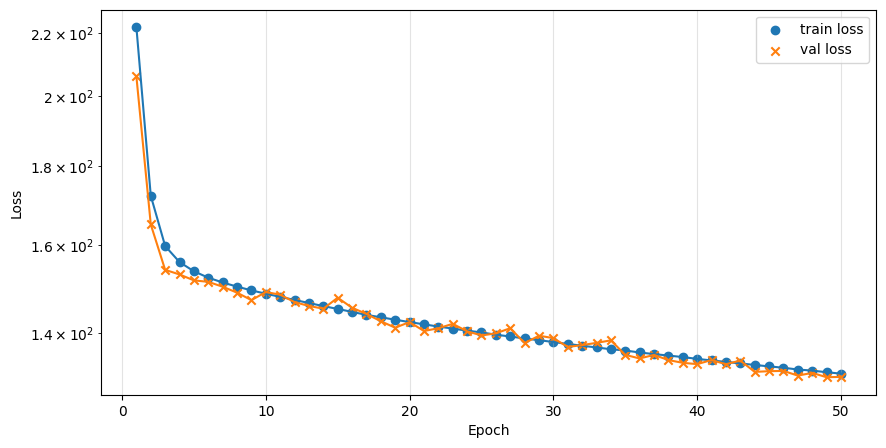

In [12]:
# define model and train

TRAIN = False

if TRAIN:
    vae = VAE(BOTTLENECK_SIZE=200)
    loss_history = train_vae(vae, trainloader, valloader, n_epochs=1000) # for me: run time ~ 24 hours
    torch.save(vae.state_dict(), 'models/cartoon_vae.pt')
    plot_loss_history(loss_history)

else:
    vae = VAE(BOTTLENECK_SIZE=200)
    vae.load_state_dict(torch.load('models/cartoon_vae.pt'))


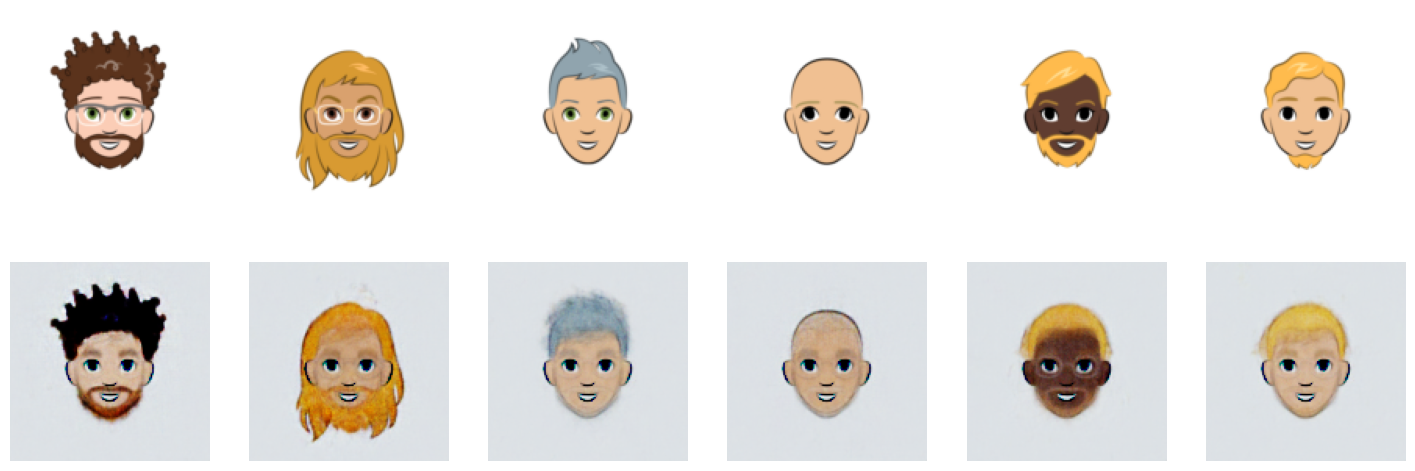

In [20]:
# plot original and reconstructions

fig, ax = plt.subplots(2, 6, figsize=(18, 6))
for i in range(6):
    ax[0, i].imshow(testloader.dataset[i][0].permute(1, 2, 0))
    ax[0, i].axis('off')
    ax[1, i].imshow(vae(testloader.dataset[i][0].unsqueeze(0))[0].squeeze().detach().permute(1, 2, 0))
    ax[1, i].axis('off')

MovieWriter imagemagick unavailable; using Pillow instead.


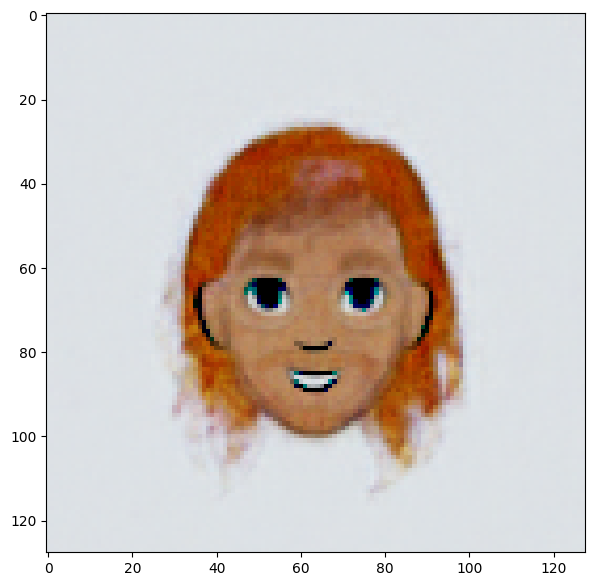

In [23]:
# do interpolation

gif = interpolate(vae, np.random.normal(0, 1, (10, 200)), 1, 'interpolation_cartoon2.gif', cartoon=True);

In [18]:
# continue the training and loss history recording

vae = VAE(BOTTLENECK_SIZE=200)
vae.load_state_dict(torch.load('models/cartoon_vae.pt'))

loss_history = train_vae(vae, trainloader, valloader, n_epochs=75)
torch.save(vae.state_dict(), 'models/cartoon_vae.pt')


100%|██████████| 125/125 [01:31<00:00,  1.36it/s]130:  99%|█████████▊| 74/75 [1:56:13<01:35, 95.72s/it]
Epoch: 75/75, train loss: 15.9252, val loss: 15.5176: 100%|██████████| 75/75 [1:57:49<00:00, 94.26s/it]


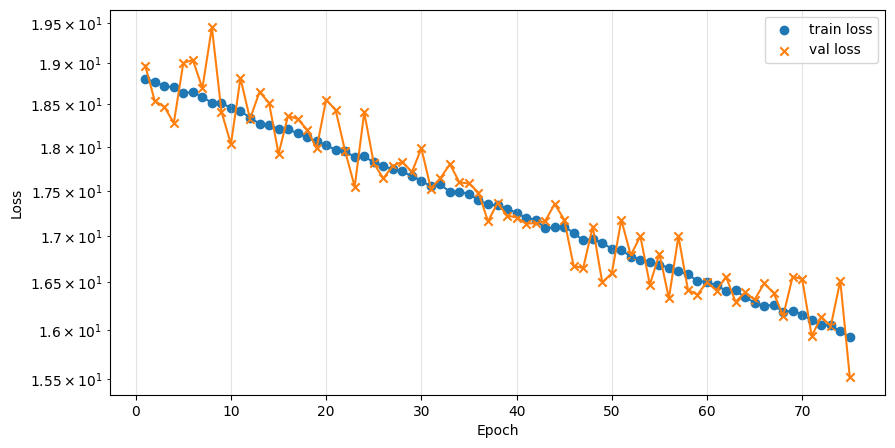

In [19]:
plot_loss_history(loss_history)